## Neural network for FX UO barrier call option

In this notebook, we train NN to price FX UO barrier call options with 1% accuracy for 78% of options. We have the following steps:

1) ***Calculate 100 000 true prices of FX UO Barrier Call Options***. We use analytical pricer to calculate true prices. We have 5-dimensional cube of 5 parameters (barrier/strike, spot/strike, time-to-maturity, interest rate and vol) where dimension in this cube represents the range of values of a certain parameter. For example, barrier/strike values have N=61 different numbers from BK_MIN=0.5 to BK_MAX=3. We randomly choose values for these 5 parameters and we calculate true Barrier option price for this set of 5 parameters. We repeat it 100 000 times. So, we get 100 000 true prices for options with different parameters. ***The procedures takes 1 minute***.

2) ***Train NN***. We use these 5 parameters as inputs in our 10-layer 100-node neural network. To have more financial meaning, we provide interest_rate\*time_to_maturity and vol\*\*2\*time_to_maturity as inputs rather than just interest_rate and vol. We use true Barrier option prices as outputs for our neural network. We minimize MSE between true option prices and predicted ones. ***The training of NN takes 30 minutes.***

3) ***Calculate the accuracy of the result***. Having trained NN, we predict Barrier option prices via NN. Then we compare predicted prices and true prices to calculate percentage of options which have better than 1% accuracy. We get that 78% of options are calculated with 1% accuracy. 

Set constants

In [2]:
import numpy as np
from math import log, exp
from scipy.stats import norm

# Setting the parameters
N = 61  # number of intermediate points in discretization
BK_MIN = 0.5 # lower bound of barrier/strike values
BK_MAX = 3 # upper bound of barrier/strike values
SK_MIN = 0.5 # spot/strike
SK_MAX = 3 # spot/strike
T_MIN = 1 / 365 # time-to-maturity in in years
T_MAX = 181 / 365  # maximum value is half a year
R_MIN = 0.0 # interest rates
R_MAX = 0.15 # interest rates
VOL_MIN = 0.05 # fx volatility
VOL_MAX = 0.4 # fx volatility
N_prices = 100_000 # number of true values calculated via barrier_pricer function
SEED = 0  # seed to select points in 5-d cube of parameters
PROB_TO_REACH_STRIKE = 0.01  # if prob of reaching strike is lower than it, we don't consider such options

bk_set = np.linspace(SK_MIN, SK_MAX, N)
sk_set = np.linspace(SK_MIN, SK_MAX, N)
t_set = np.linspace(T_MIN, T_MAX, N)
r_set = np.linspace(R_MIN, R_MAX, N)
vol_set = np.linspace(VOL_MIN, VOL_MAX, N)

## 1) Calculate 100 000 true prices of FX UO Barrier Call Option

Create pricing function for fx barrier option

In [5]:
def bar_opt_mtm_theory(b, fx0, k, t, r, vol):
    """
    # The theoretical prices are taken from
    # The Ins and Outs of Barrier Options: Part2 by Derman and Kani (p.79)
    type = 'OU'
    """
    v = vol * t**0.5

    x1 = ( log(fx0/k) + (r + vol**2 / 2) * t ) / v
    x2 = ( log(fx0/b) + (r + vol**2 / 2) * t ) / v
    term1 = fx0 * ( norm.cdf(x1) - norm.cdf(x2) )
    term2 = - k * exp(-r * t) * ( norm.cdf(x1 - v) - norm.cdf(x2 - v) )
    
    y1 = ( log(b**2/fx0/k) + (r + vol**2 / 2) * t ) / v
    y2 = ( log(b/fx0) + (r + vol**2 / 2) * t ) / v
    term3 = -fx0 * (b/fx0)**(2*r/vol**2 + 1) * ( norm.cdf(y1) - norm.cdf(y2) )
    term4 = k * exp(-r * t) * (b/fx0)**(2*r/vol**2 - 1) * ( norm.cdf(y1 - v) - norm.cdf(y2 - v) )
    
    return term1 + term2 + term3 + term4

Get the set of true prices of fx barrier options with different barrier/strike, spot/strike, time-to-maturity, interest rate, volatility and saving it to npz file. 

It takes 1 minute to obtain 100_000 samples of option prices

In [24]:
np.random.seed(SEED)
rng = np.random.default_rng()

# calculation of true prices via MC
barrier_mc_prices = np.zeros(N_prices)
bk_values = np.zeros(N_prices)
sk_values = np.zeros(N_prices)
t_values = np.zeros(N_prices)
r_values = np.zeros(N_prices)
vol_values = np.zeros(N_prices)

i = 0
while i < N_prices:
    rand_int = rng.integers(low=0, high=N, size=5)
    bk_value = bk_set[rand_int[0]]
    sk_value = sk_set[rand_int[1]]
    t_value = t_set[rand_int[2]]
    r_value = r_set[rand_int[3]]
    vol_value = vol_set[rand_int[4]]
    # cond1: when spot > barrier, an option price is always zero => we are not interested in such cases
    cond1 = sk_value < bk_value
    # cond2: when probability to reach the spot is low, an option price is close to zero => we are not very interested in such cases
    d2 = (log(sk_value) + (r_value - vol_value**2 / 2) * t_value) / (np.sqrt(t_value) * vol_value)
    cond2 = norm.cdf(d2) > PROB_TO_REACH_STRIKE
    if cond1 and cond2:
        bk_values[i] = bk_value
        sk_values[i] = sk_value
        t_values[i] = t_value
        r_values[i] = r_value
        vol_values[i] = vol_value
        barrier_mc_prices[i] = bar_opt_mtm_theory(b=bk_values[i],
                                                  fx0=sk_values[i],
                                                  k=1,
                                                  t=t_values[i],
                                                  r=r_values[i],
                                                  vol=vol_values[i])
        i += 1

## 2) Train NN

Training of NN on 90_000 samples and testing on 10_000 samples provides 1% accuracy for 78% points

The file uses:
* **MAE error**. MAPE error didn't work and provides 1% accuracy only for 1% points.
* **500 epochs**. 50 epochs shows 1% accuracy only for 51% ponts.
* **MinMaxScaler for input data** enables to have the same scale of all inputs variables, which improves the convergence. StandardScalar shows 1% accuracy only for 62% points, while the data without scalar - for 71%.
* **10 layers** because 6 or 20 layers shows 1% accuracy for 65% points
* **Batch_size=32** because 16 provides accuracy for 73% and 128 - for 50%.

The training process takes 30 minutes

In [14]:
TOL = 1e-6

# transforming parameters and barrier prices from (5D, 1D) set to the table of X and Y values
X = np.zeros((N_prices, 5))
Y = np.zeros(N_prices)
for i in range(N_prices):
    X[i, 0] = bk_values[i]/sk_values[i]
    X[i, 1] = sk_values[i]
    X[i, 2] = t_values[i]
    X[i, 3] = r_values[i] * t_values[i]
    X[i, 4] = vol_values[i] * np.sqrt(t_values[i])
    Y[i] = barrier_mc_prices[i]
    if Y[i] < TOL: Y[i] = TOL  # we change very small prices to TOL value

# data normalization to values from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

import tensorflow as tf
tf.random.set_seed(0)
model = tf.keras.models.Sequential([
  tf.keras.Input((5,)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
    
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  
  tf.keras.layers.Dense(1), # means no activation
])

model.compile(optimizer='adam', loss='MAE')

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10)

model.evaluate(X_train, Y_train, verbose=1)
model.fit(X, Y, epochs=500, verbose=1, batch_size=32)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)

2813/2813 [==============================] - 3s 923us/step - loss: 0.4170
Epoch 1/500
3125/3125 [==============================] - 6s 1ms/step - loss: 0.0400
Epoch 2/500
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0169
Epoch 3/500
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0142
Epoch 4/500
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0126
Epoch 5/500
3125/3125 [==============================] - 5s 1ms/step - loss: 0.0110
Epoch 6/500
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0104
Epoch 7/500
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0087
Epoch 8/500
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0087
Epoch 9/500
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0081
Epoch 10/500
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0076
Epoch 11/500
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0076


0.0018791597103700042

313/313 [==============================] - 0s 1ms/step


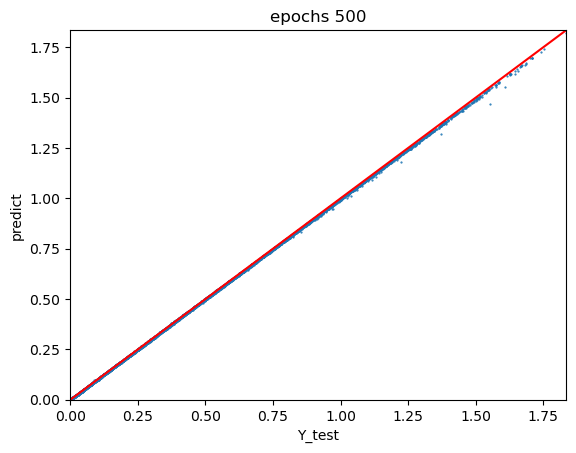

In [21]:
predict = model.predict(X_test)
import matplotlib.pyplot as plt
y_values = predict
x_values = Y_test
maxlim = max(x_values.max(), y_values.max())
plt.scatter(x_values, y_values, s=0.3)
plt.xlim([0, maxlim])
plt.ylim([0, maxlim])
plt.xlabel('Y_test')
plt.ylabel('predict')
plt.title('epochs 500')
plt.plot([0, maxlim], [0, maxlim], color='red')

## 3) Calculate the accuracy of the result

In [20]:
def accuracy_percentage (Y, predict, accuracy_level): # shows percent of points with certain accuracy_level
    tol = 1e-5
    acc_number_ = 0
    for i in range(len(Y)):
        # if true price is zero and prediction is below 1e-5 I assume that prediction is in 1% accuracy for this point
        if Y[i] == 0: 
            if abs(predict[i]) <= tol:
                acc_number_ +=1
        else:
            if abs((Y[i]- predict[i])/Y[i]) <= accuracy_level:
                acc_number_ +=1
    return acc_number_/len(Y)

# 0.01 means that a divergence is lower than 1%
print('Accuracy 1% is for', accuracy_percentage (Y_test, predict, 0.01)*100,'percentage of option prices')  

Accuracy 1% is for 77.98 percentage of option prices
